# FRTB - BA CVA 

**Introduction:<br>**
This notebook contains the implementation of the BA CVA methodology for calculating capital requirements for CVA risk. The BA-CVA (alongside the more complex SA-CVA) was introduced as part of the Basel III framework reforms, with the publication of the Fundamental Review of the Trading Book (FRTB) and CVA risk framework in 2017. Phase in was initially set for January 2022 but was pushed back to January 2023.
<br>


<u>Source</u> : https://www.bis.org/basel_framework/chapter/MAR/50.htm

**Author:** <br>
This Notebook (implementation and analysis) is the work and property of Joshua KAJI - FRM. All Rights reserved.

**Structure of the document:**<br>
The notebook is structured to facilitate comprehension of the methodology, both in terms of implementation and description. Each code cell is preceded by an explanatory note outlining the tasks undertaken, as well as the subsection reference (eg: MAR50.XX) to which it relates in the regulatory documentation.

**Table of Content:**
1) [Brief overview of the BA CVA methodology](#section1)<br>
    1.1 [Implicit model behind the BA CVA formula](#section2)<br>
    1.1 [Implementation Structure](#section2)<br>
2) [CVA Hedges](#section3)<br>
3) [Netting Set](#section3)<br>
4) [Counterparty aggregation](#section4)<br>
4) [Bank level aggregation](#section4)<br>
5) [Model Validation - Testing Portfolios](#section5)<br>
    5.1 [Test 1 - Varying Hedge Notionals](#section6)<br>
    5.2 [Test 2 - Varying Composition of Hedge Portfolio (perfect vs imperfect hedges)](#section7)<br>
    5.3 [Test 3 - Diversifying Hedges](#section8)<br>
    5.4 [Test 4 - Diversifying Couterparties in Bank Portfolio](#section9)<br>

## <a id="section1"></a> 1) Brief overview of the BA CVA methodology

### <a id="section2"></a>1.2) Implicit model behind the BA CVA formula


**<u>The hedged portfolio :</u>**
BA CVA assumes counterparty credit spreads follow a 1-factor model, where the systemic factor is the market factor $F$.

For all counterparties c:      
$$\begin{aligned}
\text{BankPortfolioCVA} &= \sum_{c} (\text{CounterpartyPortfolioCVA}_c  +\text{HedgePortfolio}_c) \\
\text{CounterpartyPortfolioCVA}_c &= \sum_{NS \in c} \text{EEPE}_{NS} \cdot \text{DF}_{NS} \cdot M_{NS} \cdot \text{CS}_{NS}\\
\text{HedgePortfolio}_c &= \text{SingleNameHedgePortfolio}_c + \text{IndexHedgePortfolio}_c\\
&= \sum_{h \in c} \text{DF}_h \cdot B_h \cdot \text{CS}_h + \sum_{ind \in c} \text{DF}_{ind} \cdot B_{ind} \cdot \text{CS}_{ind}
\end{aligned}
$$

where:
$$\begin{aligned}
\text{BankPortfolioCVA} &: \text{represents the CVA at bank level}\\
\text{CounterpartyPortfolioCVA}_c &: \text{represents the CVA at counterparty level}\\
\text{HedgePortfolio}_c &: \text{represents the CVA hedges placed by the CVA Desk}\\
\text{SingleNameHedgePortfolio}_c, \text{IndexHedgePortfolio}_c &: \text{hedges for which undelying hedged are respectively single names and indices}\\
\text{DF} &: \text{is the discount factor of the netting set or hedge}\\
B_h &: \text{is the notional of the hedging instrument}\\
\text{EEPE}_{NS} = \frac{\text{EAD}}{\alpha} &: \text{is the EEPE calculated for the netting set $c$ (via SA-CCR or IMM)}\\
\text{CS}_c, &: \text{Credit Spreads of the counterparty}\\
\text{CS}_h, &: \text{Credit Spread of a single name hedge}\\
\text{CS}_{ind} &: \text{Credit Spread of an Index hedge}\\
\end{aligned}
$$

$\text{CS}_h, \text{CS}_c, \text{CS}_{ind} $ follow 1-factor model dynamics as detailed bellow.


**<u>Counterparty Credit Spread :</u>**
BA CVA assumes counterparty credit spreads follow a 1-factor model, where the systemic factor is the market factor $F$.

For all counterparties c:      
$$\begin{aligned}
X_c &= \rho \cdot F + \sqrt{1 - \rho^2} \cdot Z_c \\
\end{aligned}
$$

where:
$$
\begin{aligned}
F, (Z_c)_{c} &\overset{\text{iid}}{\sim} \mathcal{N}(0, 1)
\end{aligned}
$$

credit spread $CS_c$ of the counterparty defined as:
$$
\begin{aligned}
CS_c &= \sigma_c  \cdot  X_c \sim \mathcal{N} (0, \sigma_c)  \\
\sigma_c &= RW_c = function(CreditQuality_c, Sector_c)
\end{aligned}
$$

**<u>Hedge Credit Spread :</u>**

BA CVA assumes that single name credit spread of hedges follow a 1-factor model, where the common factor is the the counterparty credit spread factor $X_c$.

For all hedges $h$ of counterparty $c$:     

$$\begin{aligned}
H_h &= r_{hc} \cdot X_c + \sqrt{1 - r_{hc}^2} \cdot \varepsilon_h \\
    &= r_{hc} \cdot (\rho \cdot F + \sqrt{1 - \rho^2} \cdot Z_c ) + \sqrt{1 - r_{hc}^2} \cdot \varepsilon_h \\
    &= r_{hc} \cdot \rho \cdot F + r_{hc} \cdot  \sqrt{1 - \rho^2} \cdot Z_c + \sqrt{1 - r_{hc}^2} \cdot \varepsilon_h \\
\end{aligned}
$$

where:
$$
\begin{aligned}
&F, X_c, (\varepsilon_h)_{h} \overset{\text{iid}}{\sim} \mathcal{N}(0, 1) \\
&r_{hc} = \rho(CS_h, CS_c)
\end{aligned}
$$

credit spread $CS_h$ of the hedge defined as:
$$
\begin{aligned}
CS_h &= \sigma_h  \cdot  H_h \sim \mathcal{N} (0, \sigma_h)  \\
\sigma_h &= RW_h = function(CreditQuality_h, Sector_h)
\end{aligned}
$$



**<u>Index Credit Spread :</u>**

credit spread $CS_{ind}$ of index hedge:   

$$\begin{aligned}
CS_{ind} &= \sigma_{ind} \cdot F 
\end{aligned}
$$

where:
$$
\begin{aligned}
\sigma_{ind} &= RW_{ind}  \\
    &= \sum_{SN} \omega_{SN} \cdot RW_{SN}
\end{aligned}
$$

<u>Note :</u> the RW is calculated as the weighted RW of its (single name) components. $\omega_{SN}$ represents the weight of single name constituant SN of the index

**<u>Reproducing BA CVA formula with the above :</u>**<br>

By applying the variance to the bank-level hedged portfolio, we obtain the $K_{hedged}$ formula as 

$$
\begin{aligned}
\mathbb{V}\left[BankPortfolioCVA\right] &= \mathbb{V}\left[\sum_{c} \left(\sum_{NS \in c} N_{NS} \cdot \text{CS}_{NS}  +\sum_{h \in c} N_{ind} \cdot \text{CS}_h + \sum_{ind \in c} N_{ind} \cdot \text{CS}_{ind} \right)\right]\\
&= \text{...} \\
&= K_{hedged}^2
\end{aligned}
$$


### <a id="section2"></a>1.2 Implementation Structure

The structure of classes implmented in this notebook is illustrated below. 

<br>
<details>
  <summary> class structure  </summary>
  <img src="source_images/BA_CVA_structure.png" alt="image"  width="600" />
</details>



## <a id="section3"></a> 2) CVA Hedges

Since CVA risk is considered linear to the credit spread of the counterparty with whom the bank is trading. hedging instruments are therefore instruments that change in value linearly in the oposite direction to the exposure. Intruments that may be considered hedges are specified in MAR50.18. 
<br><br>
<details>
  <summary> [50.18] :  Hedging instruments </summary>
  <img src="source_images/50.18.png" alt="image"  width="600" />
</details>

The quality of the hedge is taken into account via supervisory correlation factors that represent the correlation of the underlying credit spread of the hedging instrument and the counterparty credit spread [50.26].
<br><br>
<details>
  <summary> [50.26] :  supervisory correlation factors (single name hedges)</summary>
  <img src="source_images/50.26.png" alt="image"  width="600" />
</details>

The supervisory discount factor is defined in 50.15, 50.23, 50.24 repectively for discounting Netting set portfolios, single name hedges, Index hedges) but follows the same general formula below.
<br><br>
<details>
  <summary>   supervisory discount factor (single name hedges)</summary>
  <img src="source_images/discount_factor.png" alt="image"  width="600" />
</details>

<u>Note regarding Supervisory Discount Factor: </u><br>
The supervisory discount factor is calculated using the maturity of the netting set (respectively of the hedge). If we apply Taylor approximation to the second order, the formula of the supervisory discount factor effectively becomes a linear discount factor for a cash flow at midway point of maturity M. 

$$
\begin{aligned}
DF(M) &= \frac{1 - e^{-0.05 M}}{0.05 M}\\
    &= 1 - \frac{M}{2} 0.05
\end{aligned}
$$

The implicit assumption is that: 
- the exposure of the netting set is evenly distributed allong the maturity of the netting set
- the cash flows pertaining to hedges are evenly distributed over the life of the instrument

Risk weights represent the volatility of credit spreads and are defined by sector and credit quality in table [50.16].
<br><br>
<details>
  <summary>  [50.16] :  supervisory Risk Weights (credit spread volatilities/shocks)</summary>
  <img src="source_images/50.16.png" alt="image"  width="600" />
</details>


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 20 19:47:51 2024

@author: joshuakaji
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# [50.16] : RW table
RW_data = {
    1: [0.005, 0.02], 
    2: [0.01, 0.04], 
    3: [0.05, 0.12], 
    4: [0.03, 0.07], 
    5: [0.03, 0.085], 
    6: [0.02, 0.055], 
    7: [0.015, 0.05], 
    8: [0.05, 0.12]
}
RW = pd.DataFrame.from_dict(RW_data, orient='index', columns=['IG', 'HY'])
RW.index.name = 'sector'

def get_RW(credit_quality, sector):
    return RW.loc[sector, credit_quality]

# get weighted average RW of the index
def get_RW_index(index_composition):
    rw = sum([float(sn[0])*get_RW(sn[2], int(sn[1])) for sn in index_composition])
    return rw 

legal_connected = ['BNPP', 'BNP_CARDIF', 'BNP_UK']


# [50.26] : supervisory correlation factors between hedge name and counterparty name
def get_supervisory_correlation(hedge_name, ctp_name, legal_connection=False):
    if hedge_name == ctp_name:
        return 1
    elif legal_connection == True:
        return 0.8
    else:
        return 0.5

def get_DF(M):
    return (1 - np.exp(-0.05 * M))/0.05/M


class hedge():
    def __init__(self, name, sector, M, B, credit_quality,
                 destined_ctp, index, ctp_legal_connection=False):
        self.name = name
        self.sector = sector
        self.M = M 
        self.B = B
        self.credit_quality = credit_quality
        self.destined_ctp = destined_ctp
        self.index = index
        # Simplified : assume that indices are always specific to sector and rating 
        if index==True:
            self.rw = 0.8 * get_RW(credit_quality, sector) #get_RW_index()
        else:
            self.rw = get_RW(credit_quality, sector)
            
        # set superisory correlation to ctp
        self.r_hc = get_supervisory_correlation(name, destined_ctp, ctp_legal_connection)
        # set discount factor
        self.DF = get_DF(self.M)
        
        # legal connection : True if counterparty is a parent company or if it is the subsidiary of its parent company
        self.ctp_legal_connection = ctp_legal_connection
        
        # adjusted notional
        self.adjN = self.B *self.M * self.DF 
        
    def __str__(self):
        res_hedge = '%iY CDS on %s' %(self.M, self.name)
        res_ctp = 'CVA hedge for counterparty : %s' %(self.destined_ctp)
        res = res_ctp + ' || ' + res_hedge
        return res


## <a id="section3"></a> 3) Netting Set

The BA CVA methodology utilises the EAD exposures calculated via SA CCR of IMM. The SA CCR methodology and implementation is reviewed in notebook "SA_CCR_instrument_mapping.ipynb" and "SA_CCR_aggregation_netting_set.ipynb".
<br><br>


In [3]:
class nettingSet():
    def __init__(self, EAD, effM, name_ctp):
        self.EAD = EAD
        self.M = effM
        self.name_ctp = name_ctp 
        self.DF = get_DF(effM)

    def __str__(self):
        res = 'Netting set with counterparty %s // EAD : %i€ // Effective Maturity : %iY' % (self.name_ctp, self.EAD, self.M)
        return res

ns1 = nettingSet( 1e6, 10, 'BNPP')
print(ns1)

Netting set with counterparty BNPP // EAD : 1000000€ // Effective Maturity : 10Y


## <a id="section4"></a> 4) Counterparty level aggregation

The BA CVA methodology utilises the EAD exposures calculated via SA CCR of IMM. The SA CCR methodology and implementation is implemented and reviewed in notebook "SA_CCR_instrument_mapping.ipynb" and "SA_CCR_aggregation_netting_set.ipynb". 

For each counterparty, we must calculate various components that will later on be aggregated at the bank level portfolio:
- SCVA [50.15] : netting set CVA
- SNH [50.23] : the part of single name hedges that offset the portfolio CVA
- HMA [50.25] : the idiosyncratic components of single name hedges that are not perfect
- IH [50.24] : index hedge component
<br><br>    


<details>
  <summary>  [50.15] : SCVA : netting set component  </summary>
  <img src="source_images/50.15.png" alt="image"  width="600" />
</details><br><br>


<details>
  <summary>  [50.23] : SNH : calculating single name hedge component </summary>
  <img src="source_images/50.23.png" alt="image"  width="600" />
</details>
<br><br>
<details>
  <summary>  [50.25] : HMA : calculating Hedging Miss Alignement component </summary>
  <img src="source_images/50.25.png" alt="image"  width="600" />
</details>
<br><br>
<details>
  <summary>  [50.24] : IH : calculating Index Hedge component </summary>
  <img src="source_images/50.23.png" alt="image"  width="600" />
</details>

In [17]:

alpha = 1.4
class counterparty():
    def __init__(self, ctp, ctp_credit_quality, sector,  L_NS, L_hedge):
        self.ctp = ctp
        self.ctp_credit_quality = ctp_credit_quality
        self.sector = sector 
        self.L_NS = L_NS
        self.L_hedge = L_hedge
        # counterparty cannot be an index ... duh !
        self.rw = get_RW(ctp_credit_quality, sector)

        # [50.15] : calculate SCVA 
        self.SCVA = 1/alpha * self.rw * sum([ns.EAD * ns.M * ns.DF for ns in self.L_NS])
        
        # single names hedges
        self.hedges_sn = [h for h in L_hedge if h.index==False]
        # [50.23] : calculate Single Names Hedge
        self.SNH = sum([get_supervisory_correlation(h, self.ctp) 
                        * get_RW(h.credit_quality, h.sector)
                        * h.M * h.B * get_DF(h.M) for h in self.hedges_sn])
        # [50.25] : Single Names Miss Alignment
        self.HMA = sum([(1 - h.r_hc**2) 
                        * (h.rw * h.M * h.B * h.DF)**2 for h in self.hedges_sn])

        # [50.24] : calculate Index Hedges =>  TODO
        self.hedges_index = [h for h in L_hedge if h.index==True]
        self.IH = sum([h.rw * h.M * h.B * h.DF for h in self.hedges_index])
        self.addon = {'SCVA' : self.SCVA, 
                        'SNH' : self.SNH, 
                        'HMA' : self.HMA, 
                        'IH' : self.IH}
        self.addon_summary= pd.DataFrame(list(self.addon.items()), columns=['addOn', 'amount'])

        #hedge composition in notional
        data = []
        for h in L_hedge:
            type_underlying = 'index' if h.index else 'single name'
            data.append([h.destined_ctp, h.name, type_underlying, h.B, h.M, h.adjN, h.credit_quality, h.r_hc, h.rw])
        col_names= ['counterparty', 'hedge name', 'underlying', 'notional', 'maturity', 'adjusted notional', 'credit quality', 'correlation', 'RW']
        self.hedge_summary = pd.DataFrame(data, columns=col_names)
        # self.hedge_composition['single names perfect hedge'] = sum([h* hedges_sn])

## <a id="section4"></a> 5) Bank level aggregation

The BA CVA methodology utilises the EAD exposures calculated via SA CCR of IMM. The SA CCR methodology and implementation is implemented and reviewed in notebook "SA_CCR_instrument_mapping.ipynb" and "SA_CCR_aggregation_netting_set.ipynb". 

For each counterparty, we must calculate various components that will later on be aggregated at the bank level portfolio:
- SCVA [50.15] : netting set CVA
- SNH [50.23] : the part of single name hedges that offset the portfolio CVA
- HMA [50.25] : the idiosyncratic components of single name hedges that are not perfect
- IH [50.24] : index hedge component
<br><br>    


<details>
  <summary>  [50.14] : calculating $K_{reduced}$  </summary>
  <img src="source_images/50.14.png" alt="image"  width="600" />
</details><br><br>

<details>
  <summary>  [50.21] : calculating $K_{hedged}$  </summary>
  <img src="source_images/50.21.png" alt="image"  width="600" />
</details><br><br>

<details>
  <summary>  [50.20] : calculating $K_{full}$  </summary>
  <img src="source_images/50.20.png" alt="image"  width="600" />
</details><br><br>


In [15]:
class bank():
    def __init__(self, L_ctp):
        self.L_ctp = L_ctp
        # systemic correlation between counterparties (ie: market factor)
        rho = 0.5
        beta = 0.25
        DS = 0.65
        # [50.14] : calculate K(reduced)
        systemic_component = sum([rho*ctp.SCVA for ctp in self.L_ctp])**2
        idiosyncratic_component = (1 - rho**2) * sum([ctp.SCVA**2 for ctp in self.L_ctp])
        self.K_reduced = np.sqrt(systemic_component + idiosyncratic_component)
        # [50.21] : calculate K (hedged)
        systemic_component = (rho * sum([ctp.SCVA - ctp.SNH - ctp.IH for ctp in self.L_ctp]))**2
        idiosyncratic_component = (1 - rho**2) * sum([(ctp.SCVA - ctp.SNH)**2 for ctp in self.L_ctp])
        miss_alignement_component  = sum([ctp.HMA for ctp in self.L_ctp])
        self.K_hedged = np.sqrt(systemic_component+ idiosyncratic_component + miss_alignement_component)
        # [50.20] : calculate K (Full)
        self.K_full = beta*self.K_reduced + (1-beta)*self.K_hedged
        # [50.14] : apply discount factor 0.65
        self.BA_CVA_full = self.K_full  * DS
        self.BA_CVA_reduced = self.K_reduced  * DS
        self.data = {'K_reduced' : self.K_reduced, 
                     'K_hedged' : self.K_hedged, 
                     'K_full' : self.K_full,
                     'BA_CVA_reduced' : self.BA_CVA_reduced,
                     'BA_CVA_full' : self.BA_CVA_full, }

## <a id="section5"></a> 5) Model Validation - Testing Portfolios

In this section we test the model implemented previously with various hypothetical portfolios as inputs and study the coherance with what we expect. This input-output analysis is a high level form of model validation as for certain inputs we expect certain impacts. 
The following tests are conducted:
- test 1 : varying the notional of the hedge portfolio
- test 2 : varying the quality of hedges
- test 3 : varying the number of hedges
- test 4 : varying the number of counterparties

Whilst not full proof, this analysis is a means to highlight any major floors in implementation.

### <a id="section6"></a> 5.1) Test 1 - Varying Hedge Notionals

We set the collowing counterparty portfolio:

############################## 
 Netting set with counterparty BNPP // EAD : 1000000€ // Effective Maturity : 10Y


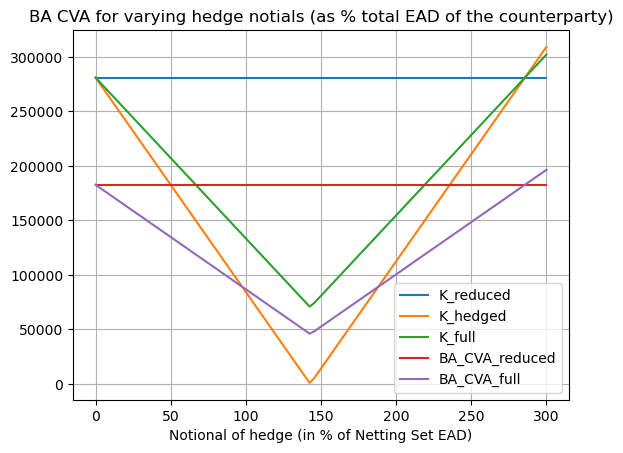

In [16]:
###############################################################################
# Test 1 : BA CVA for varying hedge notials (as % total EAD of the counterparty)
###############################################################################
# create netting set notional EAD
ctp = 'BNPP'
ead = 1e6
# for if no approval for IMM => calculate with [CRE32.46 to CRE32.54]
# duration like formula (CF weighted maturity of CFs)
effM = 10

ns1 = nettingSet(ead, effM, ctp)
print('#'*30,'\n', ns1)
L_NS = [ns1]

# create hedge portfolio
sector = 3
M = effM

ead_notional_input = np.linspace(0, 3, 100)
ead_notional_to_hedge = lambda ead_pc : [hedge('BNPP', sector, M, ead*ead_pc, 'IG', ctp, False, False)]
ead_notional_to_hedge_vector = np.vectorize(ead_notional_to_hedge)

vector_L_hedge = ead_notional_to_hedge_vector(ead_notional_input)

# create counterparty level portfolio
ctp_credit_quality = 'IG'
hedge_to_ctp = lambda L_hedge : counterparty(ctp, ctp_credit_quality, sector,  L_NS, L_hedge)
hedge_to_ctp_vector = np.vectorize(hedge_to_ctp) 
ctp_vector = hedge_to_ctp_vector(vector_L_hedge)

#col_keep_hedge_summary = ['hedge name', 'underlying', 'adjusted notional', 'correlation', 'RW']
#hedge_summary = CTP1.hedge_summary 
#addon_summary = CTP1.addon_summary
#print('\nCounterparty Summary : \n', addon_summary)
#print('\nHedge Summary : \n', hedge_summary[col_keep_hedge_summary ])

# hypothetical bank level portfolio
ctp_to_bank_to_summary = np.vectorize(lambda L_ctp : bank([L_ctp]).data)

summary = pd.concat([pd.DataFrame([dico]) for dico in ctp_to_bank_to_summary(ctp_vector)], axis=0)
summary['Notional of hedge (in % of Netting Set EAD)'] = ead_notional_input*100


summary.plot(x = summary.columns[-1], y =['K_reduced', 'K_hedged', 'K_full', 'BA_CVA_reduced', 'BA_CVA_full'], grid= True) 
plt.title("BA CVA for varying hedge notials (as % total EAD of the counterparty)")
plt.show()

**<u>output analysis</u>:**

The x-axis of the graph above represents the notional of the hedge as percentage of the EAD of the netting set. 
The capital charge is lowest (across all lines) when the notional of the hedge is 140%. This is expected since the notional of the exposure is not the EAD but the EEPE (which is obtained by dividing by 1.4 in the model). Further, we notice that the K_hedged is reduced to zero at that optimal hedge point (140% of netting set EAD), this is coherant with the fact that we used a hedge of the same underlying and maturity as that of the netting set. 

The fact that the hedge gets worse beyond the notional is expected since taking an excessive position in the opposite direction is also risk.

<u>Note</u>: <br>The lines representing K_reduced and BA_CVA_reduced are constant, this is expected since the variations we apply impact the hedge only and K_reduced and BA_CVA_reduced are do not take into account hedges.
K_hedged and BA_CVA_hedged,  BA_CVA_full are linearly sensitive to variation of the notional of the hedge, as expected. K_full is visibly a weighted average of K_reduced and K_hedged.


### <a id="section7"></a> 5.2) Test 2 - Varying Composition of Hedge Portfolio (perfect vs imperfect hedges)

One expects the quality of hedge to impact the capital charge. The higher quality the hedge with respect to the underlying (meaning the more correlated it is the the counterparty credit spread) the lower the expected capital requirements. 

In the graph below the hedging portfolio is composed of 2 hedges:
- the first with a perfect-hedge underlying (ie: the underlying is the entity of the counterparty)
- the second hedge has an imperfect underlying with respect to hedging (index hedge)

The total notional of the hedging portfolio remains constant for all scenarios however the notional of the first and second hedge vary in oposite proportionaly. 

The hedged portfolio can be written as the following :

$$
\begin{aligned}
\text{HedgedPortfolio}_{BNPP} = \text{NS}_{BNPP}(EAD) + \text{CDS}_{BNPP} \left( (1 - x) \cdot N^{NS} \right) + \text{CDS}_{SNP500} \left( x \cdot N^{NS} \right)
\end{aligned}
$$

where:
$$
\begin{aligned}
N^{NS} &= 1.4 \cdot EAD \\
x &\in [0, 1] \\
\end{aligned}
$$
With notations : 
$$
\begin{aligned}
\text{CDS}_{S} (N) &: \text{CDS on underlying S for notional amount N}\\
\text{NS}_{C}(EAD) &: \text{Netting Set with counterparty C, with aggregated Exposure At Default of EAD}
\end{aligned}
$$

############################## 
 Netting set with counterparty BNPP // EAD : 1000000€ // Effective Maturity : 10Y


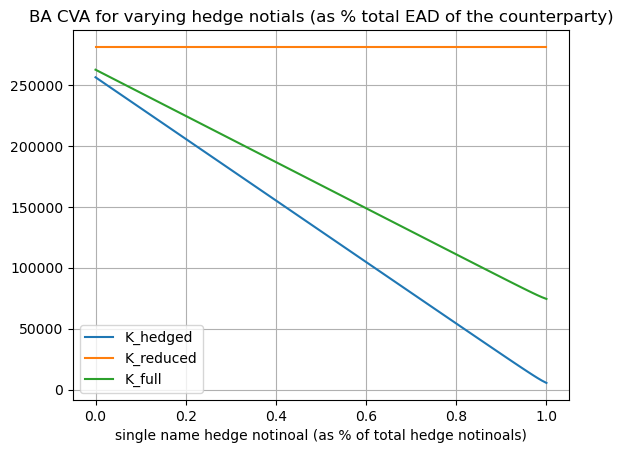

In [7]:
###############################################################################
# Test 2 : varying composition of hedge portfolio (perfect vs partial hedge)
###############################################################################
ctp = 'BNPP'
ctp_credit_quality = 'IG'
ead = 1e6
# for if no approval for IMM => calculate with [CRE32.46 to CRE32.54]
# duration like formula (CF weighted maturity of CFs)
effM = 10

ns1 = nettingSet(ead, effM, ctp)
print('#'*30,'\n', ns1)
L_NS = [ns1]

# create hedge portfolio
sector = 3
M = effM
N_total = ead*1.4
single_name_pc = np.linspace(0, 1, 100)
ead_notional_to_hedge = lambda sn_pc : [hedge('BNPP', sector, M, N_total*sn_pc, 'IG', ctp, False, False), 
                                         hedge('SNP500', sector, M, N_total*(1-sn_pc), 'IG', ctp, True, False)]
ead_notional_to_hedge_vector = np.vectorize(ead_notional_to_hedge)
vector_L_hedge = ead_notional_to_hedge_vector(single_name_pc)

# create counterparty level portfolio
hedge_to_ctp = lambda L_hedge : counterparty(ctp, ctp_credit_quality, sector,  L_NS, L_hedge)
hedge_to_ctp_vector = np.vectorize(hedge_to_ctp) 
ctp_vector = hedge_to_ctp_vector(vector_L_hedge)

# hypothetical bank level portfolio
ctp_to_bank_to_summary = np.vectorize(lambda L_ctp : bank([L_ctp]).data)

summary = pd.concat([pd.DataFrame([dico]) for dico in ctp_to_bank_to_summary(ctp_vector)], axis=0)
summary['single name hedge notinoal (as % of total hedge notinoals)'] = single_name_pc


summary.plot(x = summary.columns[-1], y =['K_hedged', 'K_reduced', 'K_full'], grid= True) 
plt.title("BA CVA for varying hedge notials (as % total EAD of the counterparty)")
plt.show()




**<u>output analysis</u>:**

The x-axis of the graph above represents the ratio of the notional of the perfect hedge (same underlying entity as counterparty)

The fact that the hedge gets worse beyond the notional is expected since taking an excessive position in the opposite direction is also risk (though now in the opposite direction).

<u>Note</u>: <br>The lines representing K_reduced and BA_CVA_reduced are constant, this is expected since the variations we apply impact the hedge only and K_reduced and BA_CVA_reduced are do not take into account hedges.
K_hedged and BA_CVA_hedged,  BA_CVA_full are linearly sensitive to variation of the notional of the hedge, as expected. K_full is visibly a weighted average of K_reduced and K_hedged.


### <a id="section8"></a> 5.3) Test 3 - Diversifying Hedges 

In this section the impact of diversification of the hedging portfolio is examined. Recall that BA CVA accounts for the idiosyncraties of imperfect hedges. such idiosyncraties dissapear with enough underlyings. 

The tested portfolios may be expressed in relation to the number of single name hedges n:

$$
\begin{aligned}
\text{HedgedPortfolio}_{BNPP} = \text{NS}_{BNPP}(EAD) + \sum_{k \in [1, n]} \text{CDS}_{SingleName(k)} \left( \frac{N^{NS}}{n} \right)
\end{aligned}
$$

where:
$$
\begin{aligned}
N^{NS} &= 1.4 \cdot EAD \\
x &\in [0, 1] \\
\end{aligned}
$$
With notations : 
$$
\begin{aligned}
\text{CDS}_{S} (N) &: \text{CDS on underlying S for notional amount N}\\
\text{NS}_{C}(EAD) &: \text{Netting Set with counterparty C, with aggregated Exposure At Default of EAD}
\end{aligned}
$$

############################## 
 Netting set with counterparty BNPP // EAD : 1000000€ // Effective Maturity : 10Y


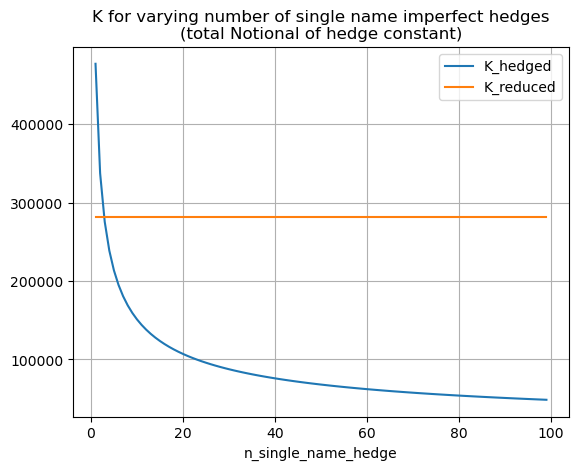

In [8]:
###############################################################################
# Test 3 : divrsifying single name (imperfect hedges)
###############################################################################
ctp = 'BNPP'
ctp_credit_quality = 'IG'
ead = 1e6
# for if no approval for IMM => calculate with [CRE32.46 to CRE32.54]
# duration like formula (CF weighted maturity of CFs)
effM = 10

ns1 = nettingSet(ead, effM, ctp)
print('#'*30,'\n', ns1)
L_NS = [ns1]

# create hedge portfolio
sector = 3
M = effM
N_total = ead*1.4

n_single_name_hedge = np.arange(1, 100)
ead_notional_to_hedge = lambda n_hedge : [hedge('single_name_%i'%sn, sector, M, N_total/n_hedge, 'IG', ctp, False, False) for sn in range(1, n_hedge+1)]
ead_notional_to_hedge_vector = np.vectorize(ead_notional_to_hedge)
vector_L_hedge = ead_notional_to_hedge_vector(n_single_name_hedge)

# check that sum of hedges have same notional 
#for L_H in vector_L_hedge[0:10]:
#    print(sum([h.B for h in L_H]))

# vector_L_hedge[0] = []

# create counterparty level portfolio
hedge_to_ctp = lambda L_hedge : counterparty(ctp, ctp_credit_quality, sector,  L_NS, L_hedge)
hedge_to_ctp_vector = np.vectorize(hedge_to_ctp) 
ctp_vector = hedge_to_ctp_vector(vector_L_hedge)

# hypothetical bank level portfolio
ctp_to_bank_to_summary = np.vectorize(lambda L_ctp : bank([L_ctp]).data)

summary = pd.concat([pd.DataFrame([dico]) for dico in ctp_to_bank_to_summary(ctp_vector)], axis=0)
summary['n_single_name_hedge'] = n_single_name_hedge

summary.plot(x = summary.columns[-1], y =['K_hedged', 'K_reduced'], grid= True) 
plt.title("K for varying number of single name imperfect hedges\n(total Notional of hedge constant)")
plt.show()



**<u>Output analysis</u>:**

The x-axis of the graph above represents the number of hedges in the portfolio. Both K_reduced and K_hedged ar represented. The capital charge decreases quadratically as the number of hedges increase. K_hedged converges towards a floor where all idiosycraties have been eliminated (see analytical proof below). 

Counterintuitively, when the number of hedges is very low, the capital charge becomes greater than the portfolio without hedge (K_reduced). The reasoning is further explained later. 

**<u>Analytical proof of convergence to floor</u>:**

<br>
It can be proven that portfolio of hedges converges towards a hedge of counterparty underlying. 

$$
\begin{aligned}
\sum_{k \in [1, n]} \text{CDS}_{SingleName(k)} (\frac{N^{NS}}{n}) &=  \sum_{k \in [1, n]} DF \cdot M \cdot \sigma \cdot \frac{N^{NS}}{n}  \cdot CS_{SingleName(k)}\\
&=  DF \cdot M \cdot \frac{N^{NS}}{n}  \sum_{k \in [1, n]} (r_{kc} \cdot X_c + (1 - r_{kc}) \cdot \varepsilon_k)\\
&\overset{n \to \infty}{\longrightarrow} DF \cdot M \cdot N^{NS} \cdot r_{kc} \cdot X_c = CDS_c(N^{NS} \cdot r_{kc})
\end{aligned}
$$
Recall previous notations/definitions : 
$$
\begin{aligned}
CS_{SingleName(k)} &= H_k \cdot \sigma \\
 H_k &= r_{kc} \cdot X_c + (1 - r_{kc}) \cdot \varepsilon_k
\end{aligned}
$$
Hence : 

$$
\boxed{
\sum_{k \in [1, n]} \text{CDS}_{\text{SingleName}(k)} \left(\frac{N^{NS}}{n}\right) 
\overset{n \to \infty}{\longrightarrow} 
\text{CDS}_c\left(N^{NS} \cdot r_{kc}\right)
}
$$

<Axes: xlabel='n_single_name_hedge'>

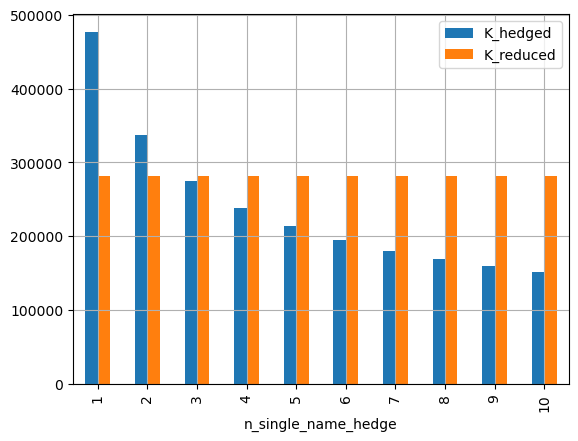

In [44]:
#print(summary.set_index('n_single_name_hedge').loc[np.arange(1, 10, 1), ['K_hedged', 'K_reduced']])

# hedge reduces risk after 3 hedges
summary.head(10).loc[:, ['n_single_name_hedge', 'K_hedged', 'K_reduced']].set_index('n_single_name_hedge').plot(kind='bar', grid = True)


In the graph above, K_hedged < K_reduced when the number of single name hedges is below 3. In other words, when there are less than 3 single name hedges, the idiosyncraties of those hedges outweigh the offsetting benefits that they procure against the counterparty credit spread exposure.

### <a id="section9"></a> 5.3) Test 4 - Diversifying Couterparties in Bank Portfolio

In this section, the bank portfolios are constructed according to varying numbers of counterparties. The counterparties are identical in terms of their parametors (netting sets within, hedges, ...).

The portfolios tested can be represented in the following : 

$$
\begin{aligned}
\text{BankPortfolio}_n = \sum_{k \in [1, n]} \text{Portfolio}_{counterparty(k)}(\text{EAD}^n_k)
\end{aligned}
$$


where:
$$
\begin{aligned}
\text{EAD}^n_k &= \frac{\text{1MEUR}}{n}\\
n &\in [1, 100]\\
\end{aligned}
$$
With notations : 
$$
\begin{aligned}
\text{Portfolio}_{\text{counterparty}(k)}(N) &: \text{represents the portfolio that the bank has with its kth } \\
&\quad \text{counterparty, for which it had an aggregated EAD amount of N}
\end{aligned}
$$

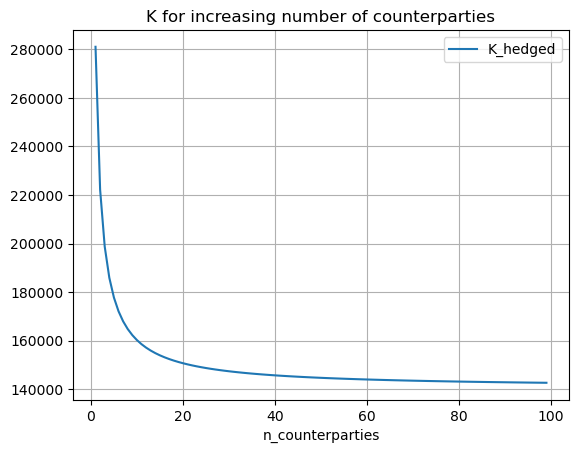

In [11]:
###############################################################################
# Test 4 : divrsifying number of counterparties
###############################################################################
ctp_credit_quality = 'IG'
ead = 1e6
# for if no approval for IMM => calculate with [CRE32.46 to CRE32.54]
# duration like formula (CF weighted maturity of CFs)
effM = 10

ns1 = nettingSet(ead, effM, ctp)

# assume no hedges
L_hedge = []
n_counterparties = np.arange(1, 100)

# create portfolio of counterparty
n_ctp_to_ctp_L = lambda n_ctp : [counterparty('ctp_%i'%ctp, ctp_credit_quality, sector,
                                              [nettingSet(ead/n_ctp, effM, 'ctp_%i'%ctp)], L_hedge) for ctp in range(1, n_ctp+1)]

n_ctp_to_ctp_L_vector = np.vectorize(n_ctp_to_ctp_L) 
ctp_vector = n_ctp_to_ctp_L_vector(n_counterparties)

# check that notional of portfolio remains constant
#for ctp_L in ctp_vector :
#    print(sum(ctp.SCVA for ctp in ctp_L))

# hypothetical bank level portfolio
ctp_L_to_bank_to_summary = np.vectorize(lambda L_ctp : bank(L_ctp).data)

summary = pd.concat([pd.DataFrame([dico]) for dico in ctp_L_to_bank_to_summary(ctp_vector)], axis=0)
summary['n_counterparties'] = n_counterparties

summary.plot(x = summary.columns[-1], y =['K_hedged'], grid= True) 
plt.title("K for increasing number of counterparties")
plt.show()

**<u>Output analysis</u>:**

The x-axis of the graph above represents the number of counterparties with whom the bank is trading. Both K_reduced and K_hedged ar represented. Similarly to the previous test, the capital charge K_hedged decreases quadratically to a certain floor as the number of counterparties increase. 

The following convergence can be proven in a similar manner as the previous proof:

$$
\begin{aligned}
\text{BankPortfolio}_n &= \sum_{k \in [1, n]} \text{Portfolio}_{counterparty(k)}(\text{EAD}^n_k)\\
&\overset{n \to \infty}{\longrightarrow} \text{Portfolio}_{Market}(\text{1MEUR} \cdot \rho)
\end{aligned}
$$

Where :
$$
\begin{aligned}
\rho : \text{correlation of single names to market factor (ie : 50%)}
\end{aligned}
$$


<u>Note</u> :<br> 
$\text{Portfolio}_{Market}(\text{1MEUR} \cdot \rho)$ is purely hypothetical since the market cannot be a counterparty. What is meant by the notation rather, is the fact that this portfolio is sensitive only to the systemic factor.